In [1]:
import pandas as pd 
from itertools import product
import os
import random

In [2]:
def get_code(offset, r0, r1, loop_num, dummy_num):
    
    code = rf"""

    ; ------------------------------------
    ; Author: Hosein Yavarzadeh 
    ; Email: hyavarzadeh@ucsd.edu
    ; Supervisor: Prof. Dean Tullsen
    ; ------------------------------------

    %define repeat0  {r0}             ; Number of repetitions of whole test. Default = 8
    %define repeat1  {r1}           ; Repeat count for loop around testcode. Default = no loop
    %define repeat2  1              ; Repeat count for repeat macro around testcode. Default = 100

    %macro testinitc 0              ; Macro to call in each test before reading counters.
        mov dword[PrintCustomPMC], 1
        mov ebx, {(r0 + 1) * (r1 + 1) * (dummy_num + 1)}             
        lea rdi, [UserData]
        rand_loop:
        rdrand eax
        and eax, 1
        mov [rdi], al
        inc rdi
        dec ebx
        jnz rand_loop

    %endmacro

    %macro testinit2 0              ; Macro with initializations before each test. Default = nothing
        lea rdi, [UserData]
    %endmacro

    %macro testcode 0               ; A multi-line macro executing any piece of test code.

        add rdi, {dummy_num}

        cmp byte[rdi],0
        
        ; dummy_branch 300, 0

        ; jmp rand_branch
        mov rax, {offset}
        mov rbx, rand_branch_back
        mov rdx, {loop_num}
        mov rcx, 0
        cmp rcx, 0
        jmp rax
        rand_branch_back:

        dummy_rand_branch {dummy_num}, 5
        ; dummy_branch {dummy_num}, 5

        lfence
        
        ; test branch
        READ_PMC_START
        cmp byte[rdi],0
        je target2
        target2:
        READ_PMC_END

    %endmacro

    %macro dummy_branch 2
        mov rax, 0
        %assign i (100)*(%2)
        %assign j (100)*(%2)
        %rep %1
                %assign j i+1
                label%+ i:
                cmp rax, 0
                je label%+ j 
                %assign i j  
        %endrep
        label%+ j:
    %endmacro
    
    %macro dummy_rand_branch 2
        mov rax, rdi
        %assign i_rand (100)*(%2)
        %assign j_rand (100)*(%2)
        %rep %1
                %assign j_rand i_rand+1
                label_rand%+ i_rand:
                inc rax
                cmp byte[rax], 0
                je label_rand%+ j_rand 
                %assign i_rand j_rand  
        %endrep
        label_rand%+ j_rand:
    %endmacro

    """
    return code

In [3]:
ld_script = r"""
/* Script for -z combreloc -z separate-code */
/* Copyright (C) 2014-2020 Free Software Foundation, Inc.
   Copying and distribution of this script, with or without modification,
   are permitted in any medium without royalty provided the copyright
   notice and this notice are preserved.  */
OUTPUT_FORMAT("elf64-x86-64", "elf64-x86-64",
	      "elf64-x86-64")
OUTPUT_ARCH(i386:x86-64)
ENTRY(_start)
SEARCH_DIR("=/usr/local/lib/x86_64-linux-gnu"); SEARCH_DIR("=/lib/x86_64-linux-gnu"); SEARCH_DIR("=/usr/lib/x86_64-linux-gnu"); SEARCH_DIR("=/usr/lib/x86_64-linux-gnu64"); SEARCH_DIR("=/usr/local/lib64"); SEARCH_DIR("=/lib64"); SEARCH_DIR("=/usr/lib64"); SEARCH_DIR("=/usr/local/lib"); SEARCH_DIR("=/lib"); SEARCH_DIR("=/usr/lib"); SEARCH_DIR("=/usr/x86_64-linux-gnu/lib64"); SEARCH_DIR("=/usr/x86_64-linux-gnu/lib");
SECTIONS
{
  PROVIDE (__executable_start = SEGMENT_START("text-segment", 0x400000)); . = SEGMENT_START("text-segment", 0x400000) + SIZEOF_HEADERS;
  .interp         : { *(.interp) }
  .note.gnu.build-id  : { *(.note.gnu.build-id) }
  .hash           : { *(.hash) }
  .gnu.hash       : { *(.gnu.hash) }
  .dynsym         : { *(.dynsym) }
  .dynstr         : { *(.dynstr) }
  .gnu.version    : { *(.gnu.version) }
  .gnu.version_d  : { *(.gnu.version_d) }
  .gnu.version_r  : { *(.gnu.version_r) }
  .rela.dyn       :
    {
      *(.rela.init)
      *(.rela.text .rela.text.* .rela.gnu.linkonce.t.*)
      *(.rela.fini)
      *(.rela.rodata .rela.rodata.* .rela.gnu.linkonce.r.*)
      *(.rela.data .rela.data.* .rela.gnu.linkonce.d.*)
      *(.rela.tdata .rela.tdata.* .rela.gnu.linkonce.td.*)
      *(.rela.tbss .rela.tbss.* .rela.gnu.linkonce.tb.*)
      *(.rela.ctors)
      *(.rela.dtors)
      *(.rela.got)
      *(.rela.bss .rela.bss.* .rela.gnu.linkonce.b.*)
      *(.rela.ldata .rela.ldata.* .rela.gnu.linkonce.l.*)
      *(.rela.lbss .rela.lbss.* .rela.gnu.linkonce.lb.*)
      *(.rela.lrodata .rela.lrodata.* .rela.gnu.linkonce.lr.*)
      *(.rela.ifunc)
    }
  .rela.plt       :
    {
      *(.rela.plt)
      PROVIDE_HIDDEN (__rela_iplt_start = .);
      *(.rela.iplt)
      PROVIDE_HIDDEN (__rela_iplt_end = .);
    }
  . = ALIGN(CONSTANT (MAXPAGESIZE));
  .init           :
  {
    KEEP (*(SORT_NONE(.init)))
  }
  .plt            : { *(.plt) *(.iplt) }
.plt.got        : { *(.plt.got) }
.plt.sec        : { *(.plt.sec) }
  . = 0x40000000;
  .text           :
  {
    b64.o (.text .stub .text.* .gnu.linkonce.t.*)
    *(.text.unlikely .text.*_unlikely .text.unlikely.*)
    *(.text.exit .text.exit.*)
    *(.text.startup .text.startup.*)
    *(.text.hot .text.hot.*)
    *(SORT(.text.sorted.*))
    a64.o (.text .stub .text.* .gnu.linkonce.t.*)
    /* .gnu.warning sections are handled specially by elf.em.  */
    *(.gnu.warning)
  }
  .fini           :
  {
    KEEP (*(SORT_NONE(.fini)))
  }
  PROVIDE (__etext = .);
  PROVIDE (_etext = .);
  PROVIDE (etext = .);
  . = ALIGN(CONSTANT (MAXPAGESIZE));
  /* Adjust the address for the rodata segment.  We want to adjust up to
     the same address within the page on the next page up.  */
  . = SEGMENT_START("rodata-segment", ALIGN(CONSTANT (MAXPAGESIZE)) + (. & (CONSTANT (MAXPAGESIZE) - 1)));
  .rodata         : { *(.rodata .rodata.* .gnu.linkonce.r.*) }
  .rodata1        : { *(.rodata1) }
  .eh_frame_hdr   : { *(.eh_frame_hdr) *(.eh_frame_entry .eh_frame_entry.*) }
  .eh_frame       : ONLY_IF_RO { KEEP (*(.eh_frame)) *(.eh_frame.*) }
  .gcc_except_table   : ONLY_IF_RO { *(.gcc_except_table .gcc_except_table.*) }
  .gnu_extab   : ONLY_IF_RO { *(.gnu_extab*) }
  /* These sections are generated by the Sun/Oracle C++ compiler.  */
  .exception_ranges   : ONLY_IF_RO { *(.exception_ranges*) }
  /* Adjust the address for the data segment.  We want to adjust up to
     the same address within the page on the next page up.  */
  . = DATA_SEGMENT_ALIGN (CONSTANT (MAXPAGESIZE), CONSTANT (COMMONPAGESIZE));
  /* Exception handling  */
  .eh_frame       : ONLY_IF_RW { KEEP (*(.eh_frame)) *(.eh_frame.*) }
  .gnu_extab      : ONLY_IF_RW { *(.gnu_extab) }
  .gcc_except_table   : ONLY_IF_RW { *(.gcc_except_table .gcc_except_table.*) }
  .exception_ranges   : ONLY_IF_RW { *(.exception_ranges*) }
  /* Thread Local Storage sections  */
  .tdata	  :
   {
     PROVIDE_HIDDEN (__tdata_start = .);
     *(.tdata .tdata.* .gnu.linkonce.td.*)
   }
  .tbss		  : { *(.tbss .tbss.* .gnu.linkonce.tb.*) *(.tcommon) }
  .preinit_array    :
  {
    PROVIDE_HIDDEN (__preinit_array_start = .);
    KEEP (*(.preinit_array))
    PROVIDE_HIDDEN (__preinit_array_end = .);
  }
  .init_array    :
  {
    PROVIDE_HIDDEN (__init_array_start = .);
    KEEP (*(SORT_BY_INIT_PRIORITY(.init_array.*) SORT_BY_INIT_PRIORITY(.ctors.*)))
    KEEP (*(.init_array EXCLUDE_FILE (*crtbegin.o *crtbegin?.o *crtend.o *crtend?.o ) .ctors))
    PROVIDE_HIDDEN (__init_array_end = .);
  }
  .fini_array    :
  {
    PROVIDE_HIDDEN (__fini_array_start = .);
    KEEP (*(SORT_BY_INIT_PRIORITY(.fini_array.*) SORT_BY_INIT_PRIORITY(.dtors.*)))
    KEEP (*(.fini_array EXCLUDE_FILE (*crtbegin.o *crtbegin?.o *crtend.o *crtend?.o ) .dtors))
    PROVIDE_HIDDEN (__fini_array_end = .);
  }
  .ctors          :
  {
    /* gcc uses crtbegin.o to find the start of
       the constructors, so we make sure it is
       first.  Because this is a wildcard, it
       doesn't matter if the user does not
       actually link against crtbegin.o; the
       linker won't look for a file to match a
       wildcard.  The wildcard also means that it
       doesn't matter which directory crtbegin.o
       is in.  */
    KEEP (*crtbegin.o(.ctors))
    KEEP (*crtbegin?.o(.ctors))
    /* We don't want to include the .ctor section from
       the crtend.o file until after the sorted ctors.
       The .ctor section from the crtend file contains the
       end of ctors marker and it must be last */
    KEEP (*(EXCLUDE_FILE (*crtend.o *crtend?.o ) .ctors))
    KEEP (*(SORT(.ctors.*)))
    KEEP (*(.ctors))
  }
  .dtors          :
  {
    KEEP (*crtbegin.o(.dtors))
    KEEP (*crtbegin?.o(.dtors))
    KEEP (*(EXCLUDE_FILE (*crtend.o *crtend?.o ) .dtors))
    KEEP (*(SORT(.dtors.*)))
    KEEP (*(.dtors))
  }
  .jcr            : { KEEP (*(.jcr)) }
  .data.rel.ro : { *(.data.rel.ro.local* .gnu.linkonce.d.rel.ro.local.*) *(.data.rel.ro .data.rel.ro.* .gnu.linkonce.d.rel.ro.*) }
  .dynamic        : { *(.dynamic) }
  .got            : { *(.got) *(.igot) }
  . = DATA_SEGMENT_RELRO_END (SIZEOF (.got.plt) >= 24 ? 24 : 0, .);
  .got.plt        : { *(.got.plt) *(.igot.plt) }
  .data           :
  {
    *(.data .data.* .gnu.linkonce.d.*)
    SORT(CONSTRUCTORS)
  }
  .data1          : { *(.data1) }
  _edata = .; PROVIDE (edata = .);
  . = .;
  __bss_start = .;
  .bss            :
  {
   *(.dynbss)
   *(.bss .bss.* .gnu.linkonce.b.*)
   *(COMMON)
   /* Align here to ensure that the .bss section occupies space up to
      _end.  Align after .bss to ensure correct alignment even if the
      .bss section disappears because there are no input sections.
      FIXME: Why do we need it? When there is no .bss section, we do not
      pad the .data section.  */
   . = ALIGN(. != 0 ? 64 / 8 : 1);
  }
  .lbss   :
  {
    *(.dynlbss)
    *(.lbss .lbss.* .gnu.linkonce.lb.*)
    *(LARGE_COMMON)
  }
  . = ALIGN(64 / 8);
  . = SEGMENT_START("ldata-segment", .);
  .lrodata   ALIGN(CONSTANT (MAXPAGESIZE)) + (. & (CONSTANT (MAXPAGESIZE) - 1)) :
  {
    *(.lrodata .lrodata.* .gnu.linkonce.lr.*)
  }
  .ldata   ALIGN(CONSTANT (MAXPAGESIZE)) + (. & (CONSTANT (MAXPAGESIZE) - 1)) :
  {
    *(.ldata .ldata.* .gnu.linkonce.l.*)
    . = ALIGN(. != 0 ? 64 / 8 : 1);
  }
  . = ALIGN(64 / 8);
  _end = .; PROVIDE (end = .);
  . = DATA_SEGMENT_END (.);
  /* Stabs debugging sections.  */
  .stab          0 : { *(.stab) }
  .stabstr       0 : { *(.stabstr) }
  .stab.excl     0 : { *(.stab.excl) }
  .stab.exclstr  0 : { *(.stab.exclstr) }
  .stab.index    0 : { *(.stab.index) }
  .stab.indexstr 0 : { *(.stab.indexstr) }
  .comment       0 : { *(.comment) }
  .gnu.build.attributes : { *(.gnu.build.attributes .gnu.build.attributes.*) }
  /* DWARF debug sections.
     Symbols in the DWARF debugging sections are relative to the beginning
     of the section so we begin them at 0.  */
  /* DWARF 1 */
  .debug          0 : { *(.debug) }
  .line           0 : { *(.line) }
  /* GNU DWARF 1 extensions */
  .debug_srcinfo  0 : { *(.debug_srcinfo) }
  .debug_sfnames  0 : { *(.debug_sfnames) }
  /* DWARF 1.1 and DWARF 2 */
  .debug_aranges  0 : { *(.debug_aranges) }
  .debug_pubnames 0 : { *(.debug_pubnames) }
  /* DWARF 2 */
  .debug_info     0 : { *(.debug_info .gnu.linkonce.wi.*) }
  .debug_abbrev   0 : { *(.debug_abbrev) }
  .debug_line     0 : { *(.debug_line .debug_line.* .debug_line_end) }
  .debug_frame    0 : { *(.debug_frame) }
  .debug_str      0 : { *(.debug_str) }
  .debug_loc      0 : { *(.debug_loc) }
  .debug_macinfo  0 : { *(.debug_macinfo) }
  /* SGI/MIPS DWARF 2 extensions */
  .debug_weaknames 0 : { *(.debug_weaknames) }
  .debug_funcnames 0 : { *(.debug_funcnames) }
  .debug_typenames 0 : { *(.debug_typenames) }
  .debug_varnames  0 : { *(.debug_varnames) }
  /* DWARF 3 */
  .debug_pubtypes 0 : { *(.debug_pubtypes) }
  .debug_ranges   0 : { *(.debug_ranges) }
  /* DWARF Extension.  */
  .debug_macro    0 : { *(.debug_macro) }
  .debug_addr     0 : { *(.debug_addr) }
  .gnu.attributes 0 : { KEEP (*(.gnu.attributes)) }
  /DISCARD/ : { *(.note.GNU-stack) *(.gnu_debuglink) *(.gnu.lto_*) }

"""

In [4]:
def create_nasm(cnt, cnt2, offset, loop_num, dummy_num, r0, r1):
    nasm_new_sections = ''
    for i in range(cnt):
        nasm_new_sections += f"""
SECTION .dummy_branch_{i} exec
    dummy_label_{i}:
    je dummy_label_{i+1}

"""
    nasm_new_sections += f"""
SECTION .dummy_branch_{cnt} exec
    dummy_label_{cnt}:
    lfence
    dec rdx
    cmp rdx, 0
    jmp dummy_label_{cnt+1}

SECTION .dummy_branch_{cnt+1} exec
    dummy_label_{cnt+1}:
    je dummy_label_{cnt+2}
    lfence
    mov rax, {offset}
    mov rcx, 0
    cmp rcx, 0
    jmp rax
"""

    for i in range(cnt+2,cnt+2+cnt2):
        nasm_new_sections += f"""
SECTION .dummy_branch_{i} exec
    dummy_label_{i}:
    je dummy_label_{i+1}

"""

    nasm_new_sections += f"""
SECTION .dummy_branch_{cnt+2+cnt2} exec
    dummy_label_{cnt+2+cnt2}:
    lfence
    
    cmp byte[rdi],0
    jmp dummy_label_{cnt+3+cnt2}

SECTION .dummy_branch_{cnt+3+cnt2} exec
    dummy_label_{cnt+3+cnt2}:
    je dummy_label_{cnt+4+cnt2}
    jmp dummy_label_{cnt+4+cnt2}

SECTION .dummy_branch_{cnt+4+cnt2} exec
    dummy_label_{cnt+4+cnt2}:
    jmp rbx
"""
    with open("bp.nasm", "w") as file:
      file.write(get_code(hex(offset), r0, r1, loop_num, dummy_num) + nasm_new_sections)

In [5]:
def create_ld(spec, a, b, cnt, cnt2, stride=0x10000000, offset=0x100000000, flip_mask=0x0, crit_bits=0x0):
  ld_new_sections = ''
  cnt = cnt + cnt2
  for i in range(cnt):
    ld_new_sections += f"""
    . = {hex(offset + (i * stride) & 0xfffff0000000 if (i == spec) else offset + i * stride)};
    .dummy_branch_{i} : {{ *(.dummy_branch_{i}) }}
  """

  # ld_new_sections += f"""
  #   . = {hex(0x100000000 + cnt * stride + ((1 << a) if a >= 0 else 0))};
  #   .dummy_branch_{cnt} : {{ *(.dummy_branch_{cnt}) }}
  # """

  # ld_new_sections += f"""
  #   . = {hex(0x100000000 + (cnt + 1) * stride + ((b << b) if a >= 0 else 0))};
  #   .dummy_branch_{cnt + 1} : {{ *(.dummy_branch_{cnt + 1}) }}
  # """
  
  # b_addr = 0x100000000 + cnt * stride + random.randint(0, ((1 << a) if a >= 0 else 0)) & 0xffffffffdf # 0x20
  # b_addr = 0x100000000 + cnt * stride + 0x315a2fb ^ flip_mask
  b_addr = 0x100000000 + cnt * stride
  b_addr = b_addr | crit_bits
  b_addr = b_addr ^ flip_mask

  
  ld_new_sections += f"""
    . = {hex(b_addr)};
    .dummy_branch_{cnt} : {{ *(.dummy_branch_{cnt}) }}
  """
  
  t_addr = 0x100000000 + (cnt + 1) * stride + random.randint(0, ((1 << b) if b >= 0 else 0)) # 0x20

  ld_new_sections += f"""
    . = {hex(t_addr)};
    .dummy_branch_{cnt + 1} : {{ *(.dummy_branch_{cnt + 1}) }}
  """

  ld_new_sections += '}'

  with open("script.ld", "w") as file:
      file.write(ld_script + ld_new_sections)
      
  return b_addr, t_addr

In [6]:
def sf1(s):
    if s == 0:
        return 0
    return 1 << (s - 1)

In [7]:
repeat0 = 20
repeat1s = range(500,2001,100)

start = 10
end = 10

loop_nums = range(200, 201)

i = 26
j = 26

cnt2s = range(0, 1)
dummy_nums = range(0, 21)

cnts = range(10, 11)
ls = range(0,1)
ks = range(56,64)
iter_product = product(repeat1s, cnts, cnt2s, loop_nums, dummy_nums, ls, ks)

lst = []

In [8]:
for repeat1, cnt, cnt2, loop_num, dummy_num, l, k in iter_product:
    create_nasm(cnt, cnt2, 0x100000000 + sf1(l), loop_num, dummy_num, repeat0, repeat1)
    b_addr, t_addr = create_ld(100, i, j, cnt + 3, cnt2, (1 << 30), 0x100000000 + sf1(l), 0, k)
    os.system(f"./run.sh {start} {end}")

    data = pd.read_csv("results.csv", comment='#', delim_whitespace=True)
    data["Clock"] = pd.to_numeric(data["Clock"],errors='coerce')
    data["BrRetired"] = pd.to_numeric(data["BrRetired"],errors='coerce')
    data["BrMispred"] = pd.to_numeric(data["BrMispred"],errors='coerce')
    data["Clock"] = (data["Clock"]) / repeat1
    data["BrRetired"] = data["BrRetired"] / repeat1
    data["BrMispred"] = data["BrMispred"] / repeat1
    lst.append((repeat1, cnt, cnt2, loop_num, dummy_num, l, k, b_addr,t_addr,data["BrMispred"].mean(),data["BrMispred"].min(),data["BrMispred"].max()))

df = pd.DataFrame(lst, columns=['repeat1', 'cnt', 'cnt2', 'loop_num', 'dummy_num', 'l', 'k', 'b_addr', 't_addr', 'BrMispred_mean', 'BrMispred_min', 'BrMispred_max'])

In [9]:
# df.to_csv('script_2_0.csv')

In [10]:
# df = pd.read_csv('script_2_0.csv')

In [11]:
display_df = df.copy()
display_df['b_addr'] = display_df['b_addr'].map('0x{:x}'.format)
display_df['t_addr'] = display_df['t_addr'].map('0x{:x}'.format)
display(display_df)

,repeat1,cnt,cnt2,loop_num,dummy_num,l,k,b_addr,t_addr,BrMispred_mean,BrMispred_min,BrMispred_max
0,500,10,0,200,0,0,56,0x440000038,0x483f86cba,0.000300,0.0000,0.0020
1,500,10,0,200,0,0,57,0x440000039,0x4803de6ba,0.000300,0.0000,0.0020
2,500,10,0,200,0,0,58,0x44000003a,0x483c97c29,0.000300,0.0000,0.0020
3,500,10,0,200,0,0,59,0x44000003b,0x482d729d8,0.000300,0.0000,0.0020
4,500,10,0,200,0,0,60,0x44000003c,0x482d3efc6,0.000400,0.0000,0.0020
...,...,...,...,...,...,...,...,...,...,...,...,...
2683,2000,10,0,200,20,0,59,0x44000003b,0x482703eba,0.498350,0.4760,0.5185
2684,2000,10,0,200,20,0,60,0x44000003c,0x482f52e31,0.497275,0.4745,0.5145
2685,2000,10,0,200,20,0,61,0x44000003d,0x4828f3359,0.500800,0.4795,0.5325
2686,2000,10,0,200,20,0,62,0x44000003e,0x483fe747f,0.503725,0.4885,0.5275


In [12]:
plot_dfs = []
for repeat1 in repeat1s:
    plot_df = pd.DataFrame()
    for k in ks:
        llist = []
        for dummy_num in dummy_nums:
            tmp = (display_df[(display_df['k'] == k) & (display_df['dummy_num'] == dummy_num)])
            llist.append(tmp['BrMispred_mean'].sum())
        plot_df[hex(k)] = llist
    plot_dfs.append(plot_df)


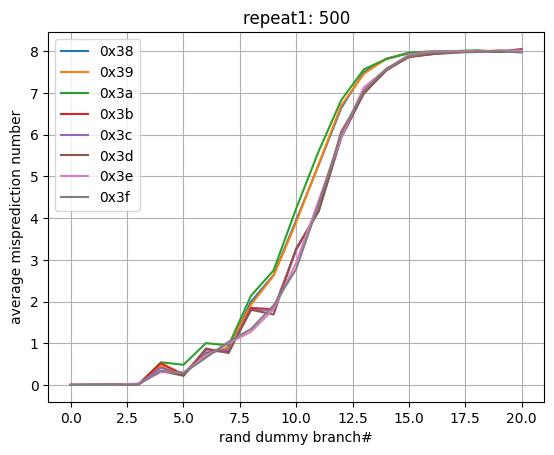

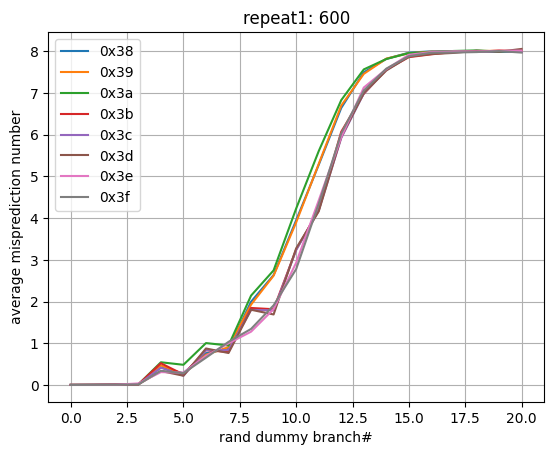

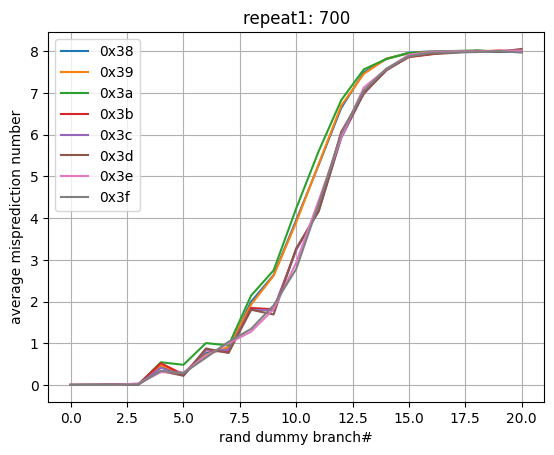

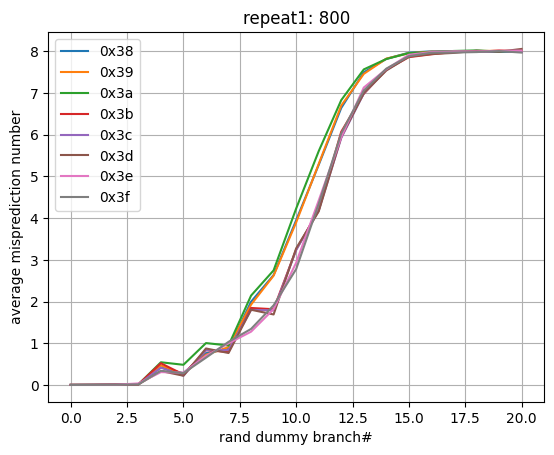

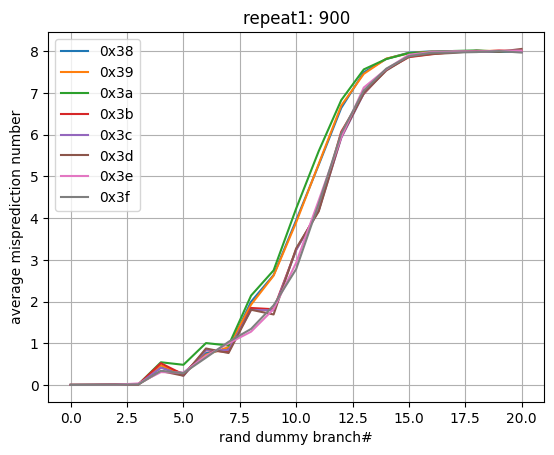

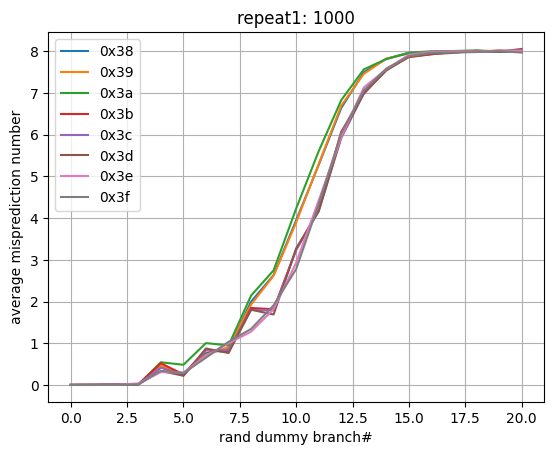

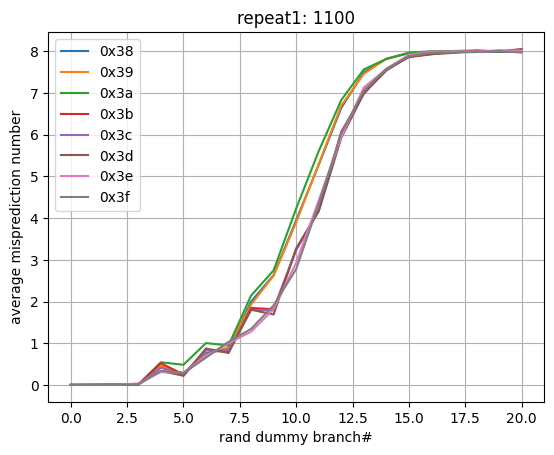

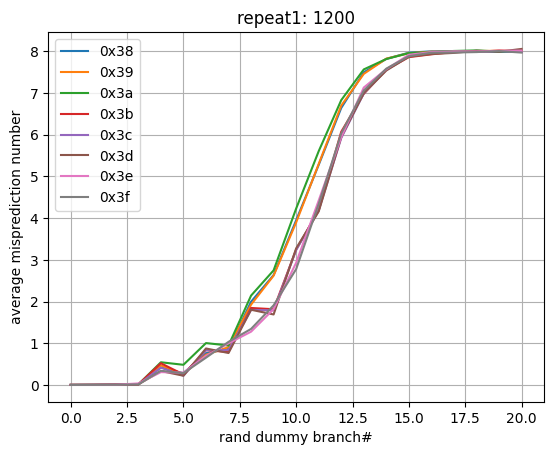

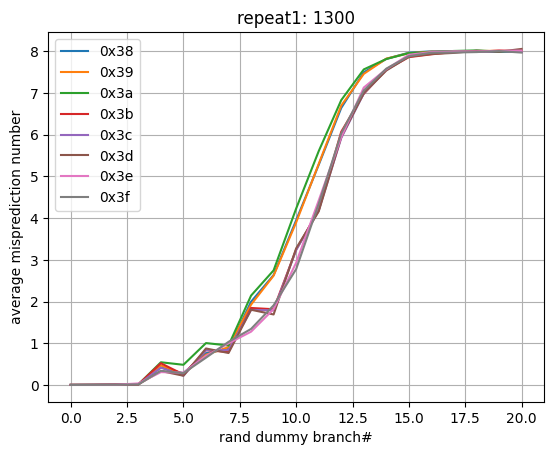

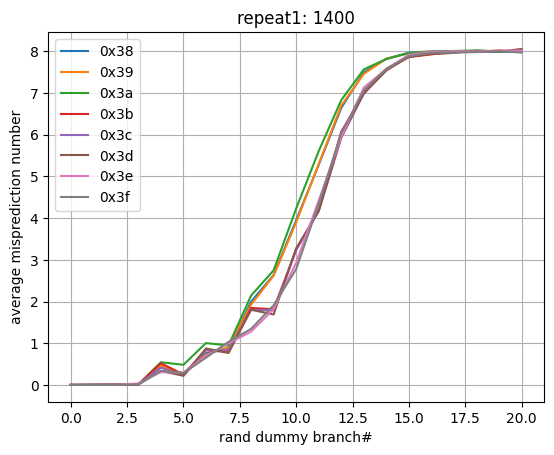

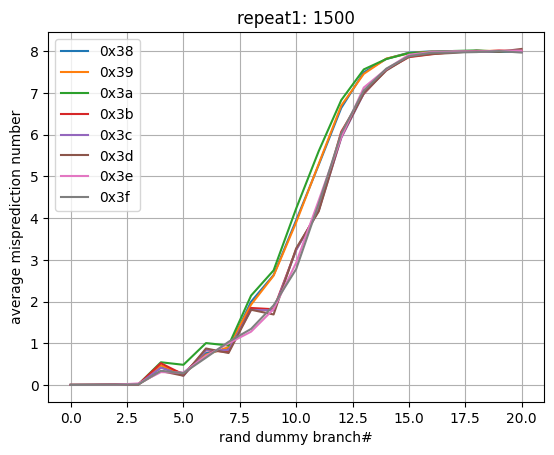

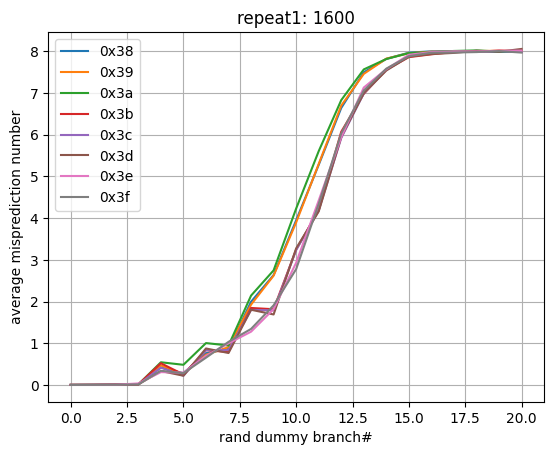

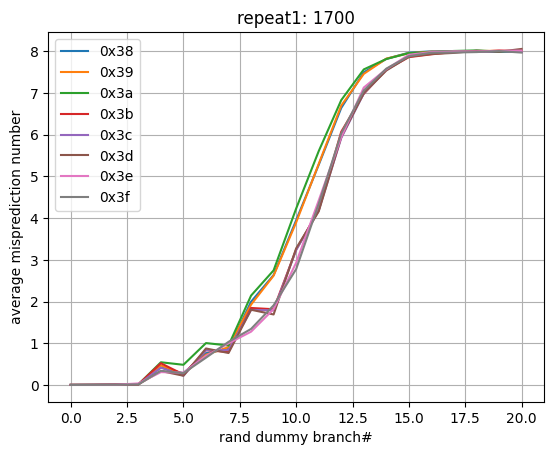

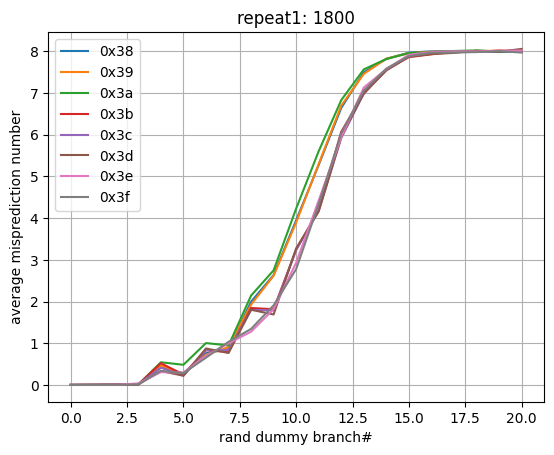

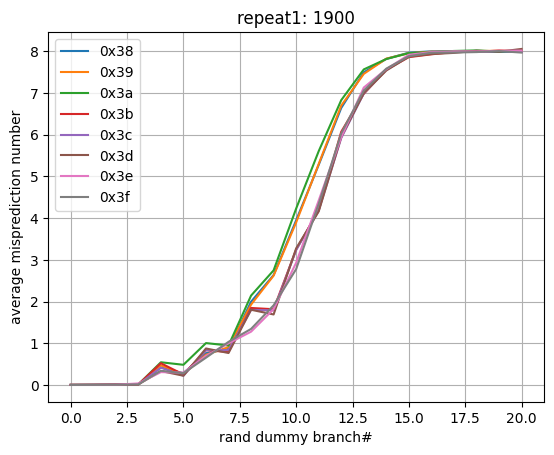

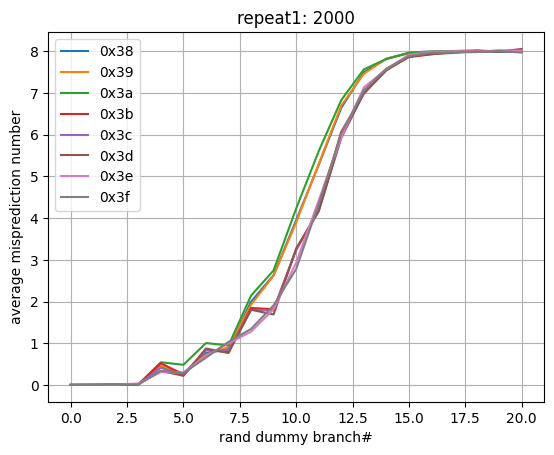

In [14]:
for repeat1 in repeat1s:
    plot_df.plot(xlabel='rand dummy branch#', ylabel='average misprediction number', grid=True, title=f'repeat1: {repeat1}')